In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'oKvZWxsSK2x-jXsvr6PL'

In [3]:
#Data pulls the Bank Prime Loan Rate, the base rate that is used for every sort of loans to prime customers
#Real estate mortgage rates are commonly based on this %

data= quandl.get('FRED/DPRIME')

In [ ]:
# https://data.nasdaq.com/data/FRED/documentation

In [4]:
data.head(5)

,Value
Date,
1955-08-04,3.25
1955-08-05,3.25
1955-08-08,3.25
1955-08-09,3.25
1955-08-10,3.25


In [5]:
data.dtypes

Value    float64
dtype: object

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

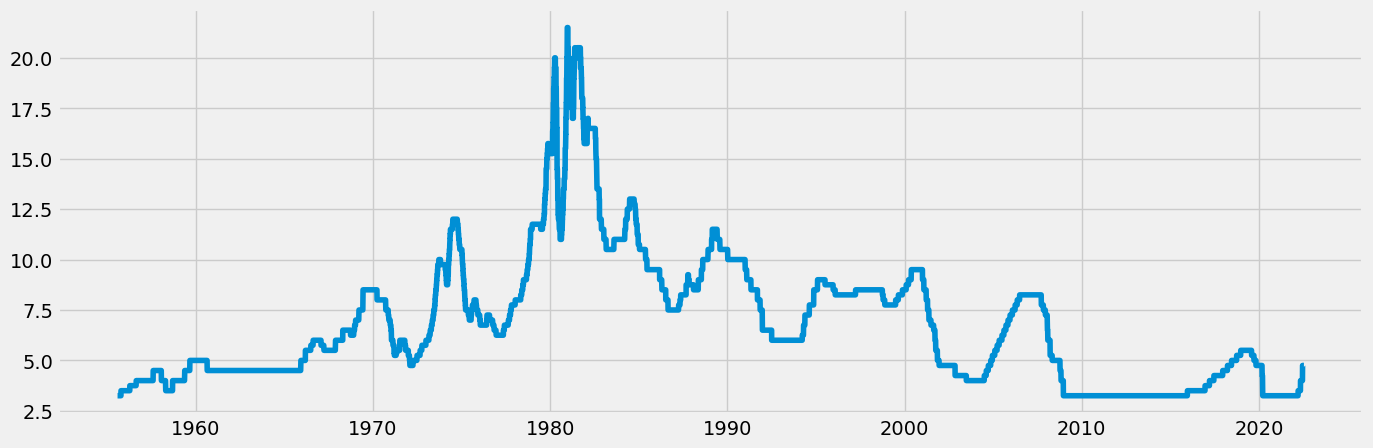

In [8]:
plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [9]:
#Instead of date being the index, it is now the column's name

data_2 = data.reset_index()

In [10]:
data_2.columns

Index(['Date', 'Value'], dtype='object')

In [11]:
data_sub = data_2.loc[(data_2['Date'] >= '1990-01-01') & (data_2['Date'] < '2007-12-30')]

In [12]:
data_sub.shape

(4521, 2)

In [13]:
data_sub.head()

,Date,Value
8878,1990-01-02,10.5
8879,1990-01-03,10.5
8880,1990-01-04,10.5
8881,1990-01-05,10.5
8882,1990-01-08,10.0


In [14]:
from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1990-01-02,10.5
1990-01-03,10.5
1990-01-04,10.5
1990-01-05,10.5
1990-01-08,10.0


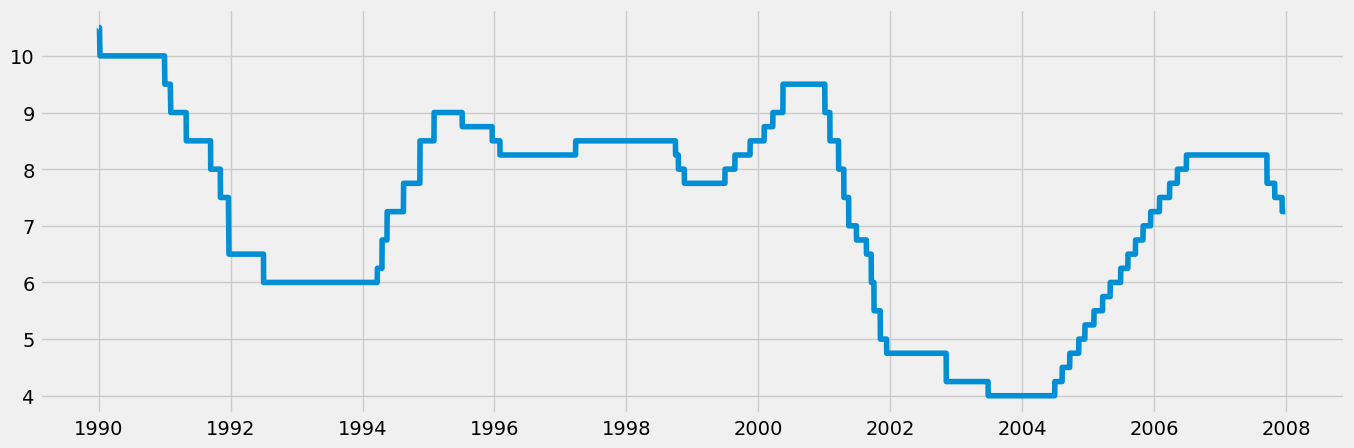

In [15]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [16]:
data_sub.isnull().sum() 

Value    0
dtype: int64

In [17]:
dups = data_sub.duplicated()
dups.sum()

4497

In [ ]:
#Duplicates are not as straight forward here, there can be multiple similar dates and values that are not duplicates

### 3. Time-series analysis: decomposition

In [30]:
decomposition = seasonal_decompose(x=data_sub['Value'], model='Multiplicative', extrapolate_trend='freq', period=1)

In [31]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

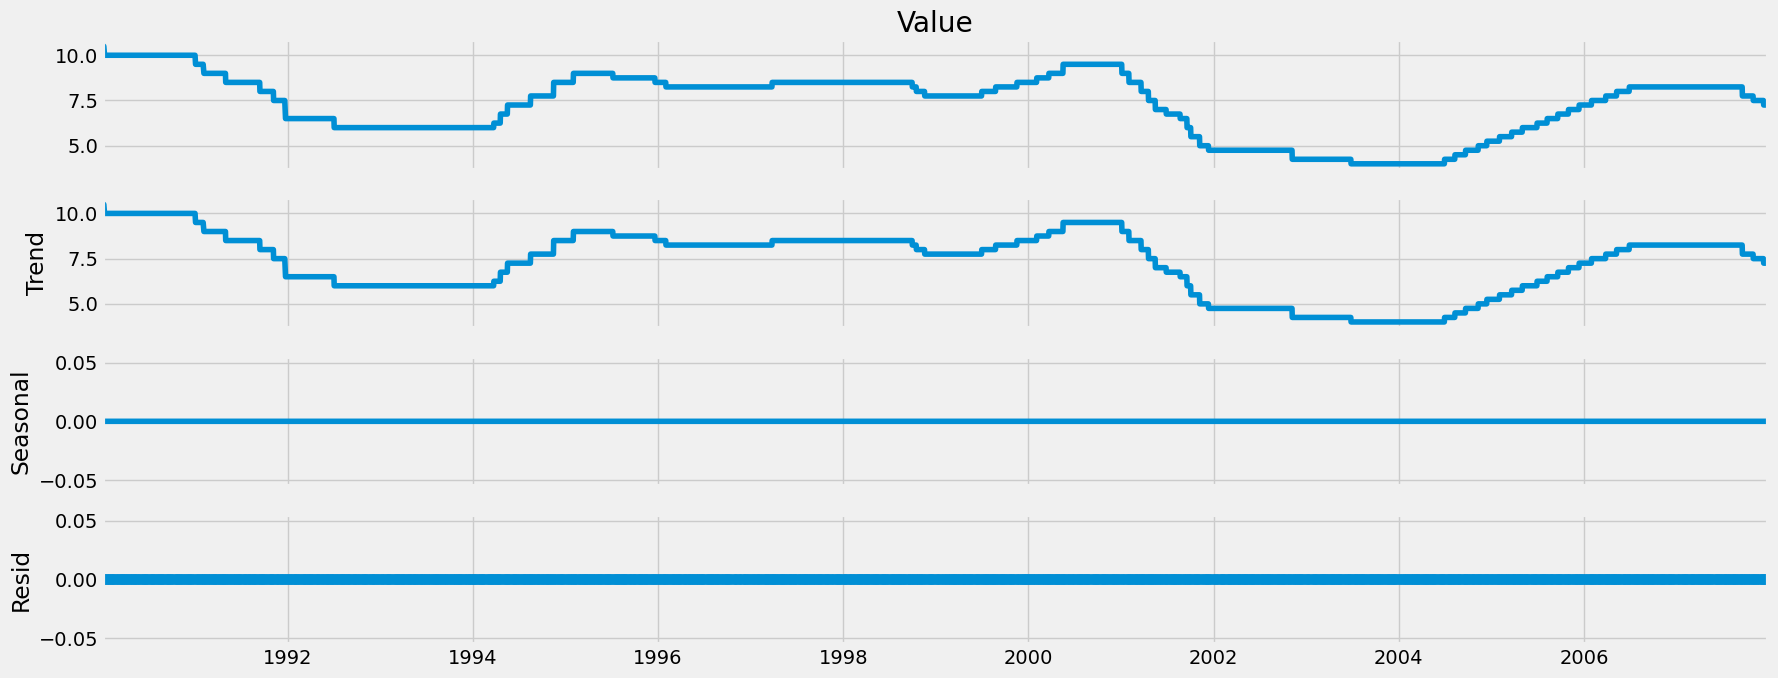

In [32]:
decomposition.plot()
plt.show()

In [ ]:
#Pretty much completely flat for seasonal and resid? , no seasonality to the fluctuations. 

#I would say this data is stationary as the trend doesn't have an obvious positive or negative slope,
#Fluctuations across the decades. We have forced stationary now

#What we can takeaway is that over the course of 1990 to 2007, the interest rates generally decrease
#Waves of 4 years of decrease, 2 years of increase, stagnant for 4 years, slight decrease, increase to 2000s
#Major decrease in interest rate in 2000 to 2004 era , which surely encouraged mortgage loans
#Even in 2007 range, the interest rates were lower than the 1990s. 
#Meaning America was in a better financial situation
#More consumer spending and greater home sales than the 90s.

## 4. Dickey-Fuller test

In [33]:
from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries): 
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   -1.762919
p-value                           0.399021
Number of Lags Used              31.000000
Number of Observations Used    4489.000000
Critical Value (1%)              -3.431808
Critical Value (5%)              -2.862184
Critical Value (10%)             -2.567113
dtype: float64


In [ ]:
# Test staistic greater than Critical value at 5%,10% , not good.

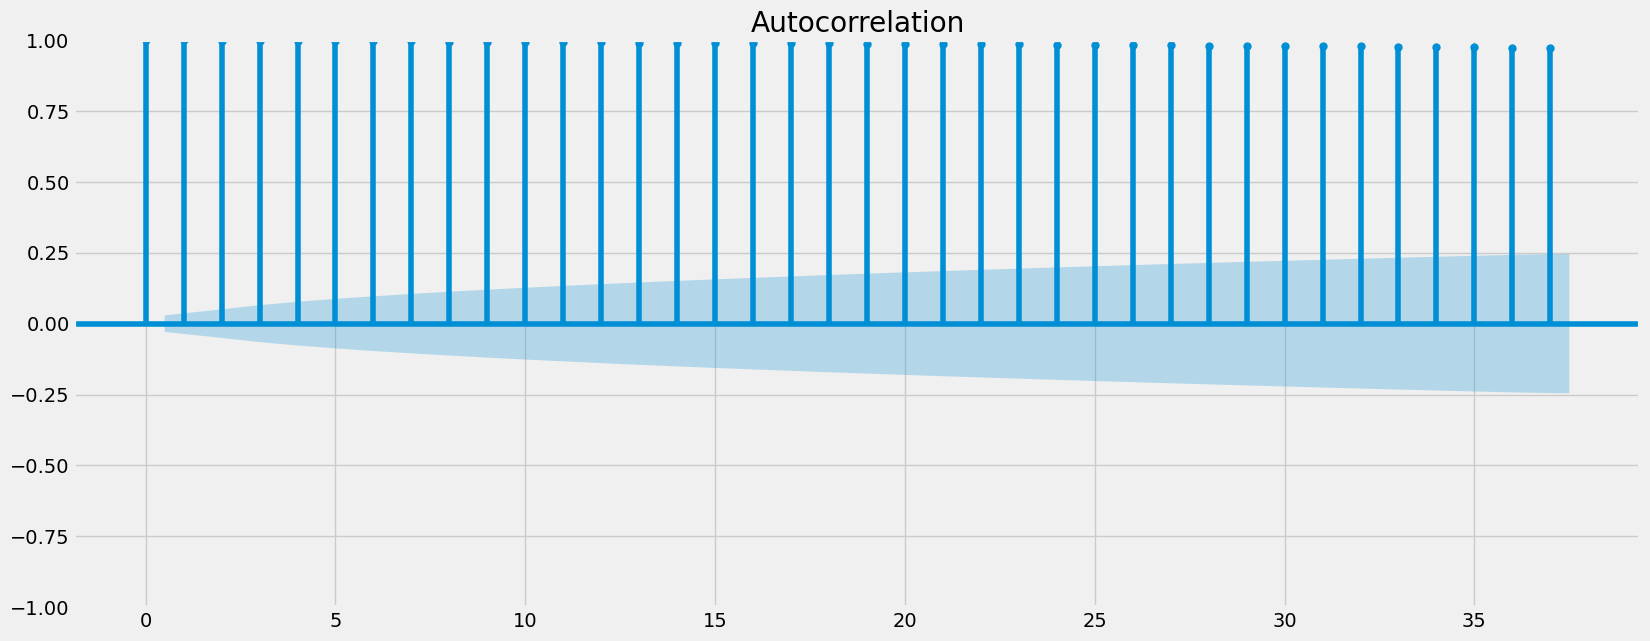

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

In [ ]:
#Showing this is non stationary still on a graph

## Further Stationarizing 

In [35]:
data_diff = data_sub - data_sub.shift(1)

In [36]:
data_diff.dropna(inplace = True)

In [37]:
data_diff.head()

,Value
datetime,
1990-01-03,0.0
1990-01-04,0.0
1990-01-05,0.0
1990-01-08,-0.5
1990-01-09,0.0


In [38]:
data_diff.columns

Index(['Value'], dtype='object')

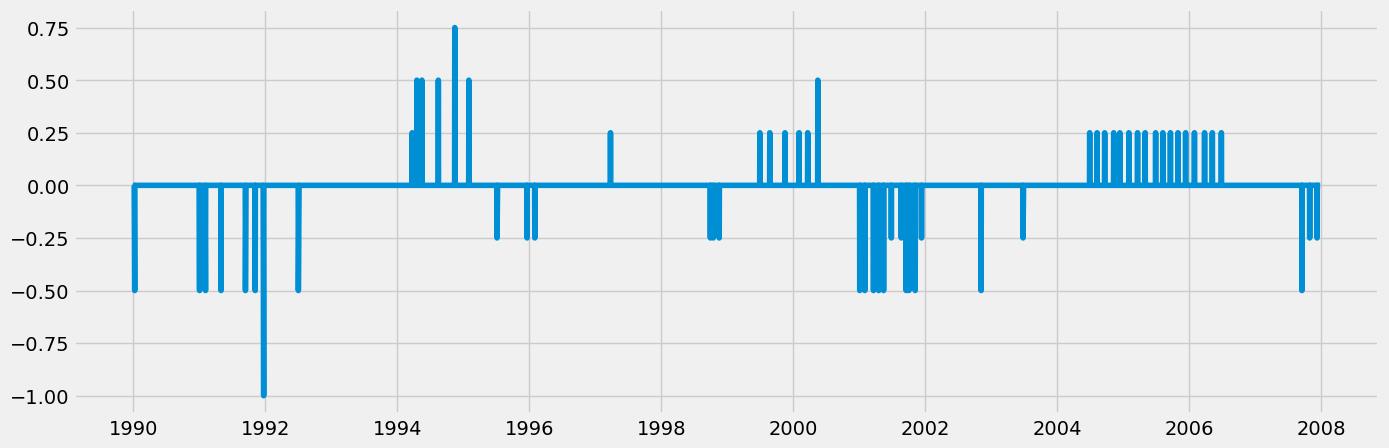

In [39]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [40]:
#Re running dickey fuller test to see if data is now stationary

dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -8.033469e+00
p-value                        1.930430e-12
Number of Lags Used            3.200000e+01
Number of Observations Used    4.487000e+03
Critical Value (1%)           -3.431808e+00
Critical Value (5%)           -2.862184e+00
Critical Value (10%)          -2.567113e+00
dtype: float64


In [ ]:
#Test statistic is now less than the critical values, showing it is now stationary

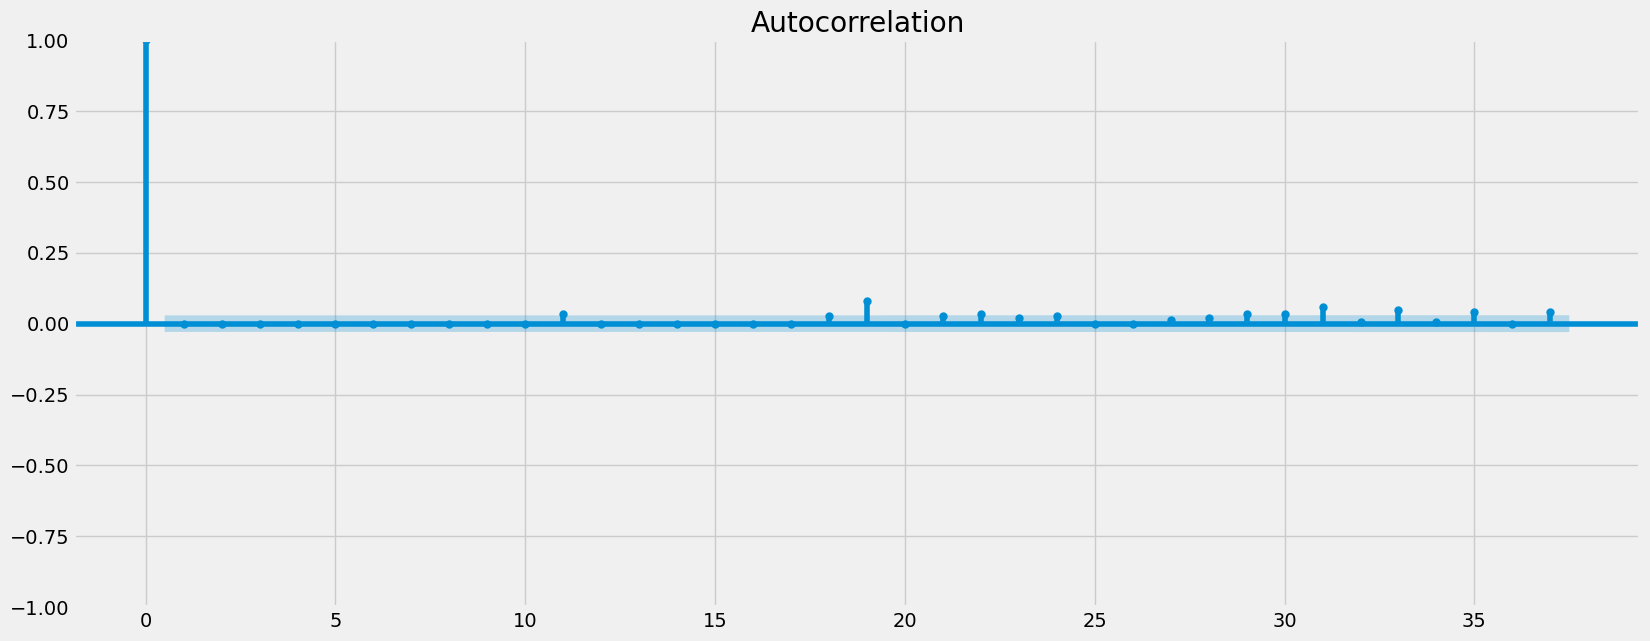

In [41]:
plot_acf(data_diff)
plt.show()

In [ ]:
#Majority of data is within the blue, making this stationary